Importing Libraries

Pipeline 

1) Read image
2) Histogram binning and simple segmentation
3) Calculate average height of each bin
4) Generate point cloud strip

In [306]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
from glob import glob
import cv2
from scipy.optimize import minimize

Reading test image

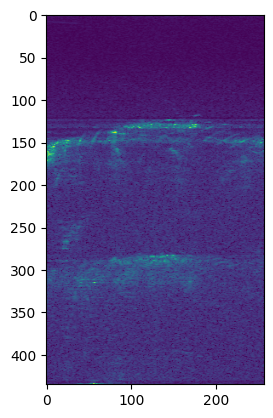

In [329]:
test_img=cv2.imread("test_4.png",0)
#test_img=cv2.rotate(test_img,0)
#plt.figure(figsize=(1,15))
plt.imshow(test_img)

CFAR filter

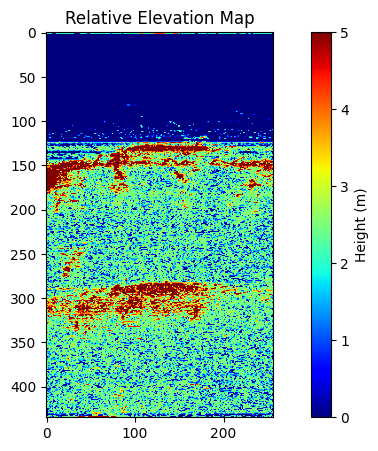

In [330]:
roi = test_img

# Reshape ROI into a 1D vector
Z = roi.reshape((-1, 1))
Z = np.float32(Z)

# K-Means Clustering
K = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Sort Clusters (Ascending Intensity)
center = np.uint8(center)
sorted_idx = np.argsort(center.flatten())
heights = np.linspace(0, 5, K)  # Example height range [0, 0.2 meters]

# Assign Heights
height_map = np.zeros_like(label, dtype=float)
for i, idx in enumerate(sorted_idx):
    height_map[label.flatten() == idx] = heights[i]

# Reshape back to image size
height_map = height_map.reshape(roi.shape)

# VisualizationT
plt.figure(figsize=(10, 5))
plt.imshow(height_map, cmap="jet")
plt.colorbar(label="Height (m)")
plt.title("Relative Elevation Map")
plt.show()


In [367]:
t=15
s=12
K=3
R_max=5
Z = roi.reshape((-1, 1)).astype(np.float32)
H,W=roi.shape
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
sorted_idx = np.argsort(center.flatten())
elevation_angles = np.linspace(t, t+s/2, K)  # Descending order

# Create Elevation Map
elevation_map = np.zeros_like(label, dtype=float)
for i, idx in enumerate(sorted_idx):
    elevation_map[label.flatten() == idx] = elevation_angles[i]
    
elevation_map = elevation_map.reshape((H, W))
elevation_map=cv2.GaussianBlur(elevation_map,(35,35),0)
# Apply Jet Colormap
#norm_elevation_map = (elevation_map - elevation_map.min()) / (elevation_map.max() - elevation_map.min())
#jet_colormap = plt.cm.jet(norm_elevation_map)[:, :, :3]  # Remove alpha channel
norm_elevation_map = (roi - roi.min()) / (roi.max() - roi.min())
jet_colormap = plt.cm.jet(norm_elevation_map)[:, :, :3]  # Remove alpha channel

# Generate Point Cloud



In [368]:
H_fls = 1.4
R_max=5
FOV=40
def cost_function(params,r):
    h_obj, theta = params
    return np.abs(H_fls - h_obj - r * np.cos(np.radians(theta)))
optimized_map = np.copy(elevation_map)
points = []
colors = []

# Run Optimization
for y in range(250,350):
    r = (y/H)*R_max  # Direct range from x index
    
    for x in range(W):
        
        theta=(x/W)*FOV-FOV/2
        print(theta)
        #initial_guess = [0.0, elevation_map[y, x]]  # Initial h_obj and theta
        #result = minimize(cost_function, initial_guess, args=(r), method='Powell',options={'maxiter': 10})
        #optimized_map[y, x] = result.x[1]
    
        
        points.append([r*np.sin(np.deg2rad(theta)), r*np.cos(np.deg2rad(theta)), r * np.sin(np.radians(elevation_map[y, x]))])
        intensity = roi[y, x] / 255.0
        colors.append(plt.cm.jet(intensity)[:3])

# Point Cloud


-20.0
-19.84375
-19.6875
-19.53125
-19.375
-19.21875
-19.0625
-18.90625
-18.75
-18.59375
-18.4375
-18.28125
-18.125
-17.96875
-17.8125
-17.65625
-17.5
-17.34375
-17.1875
-17.03125
-16.875
-16.71875
-16.5625
-16.40625
-16.25
-16.09375
-15.9375
-15.78125
-15.625
-15.46875
-15.3125
-15.15625
-15.0
-14.84375
-14.6875
-14.53125
-14.375
-14.21875
-14.0625
-13.90625
-13.75
-13.59375
-13.4375
-13.28125
-13.125
-12.96875
-12.8125
-12.65625
-12.5
-12.34375
-12.1875
-12.03125
-11.875
-11.71875
-11.5625
-11.40625
-11.25
-11.09375
-10.9375
-10.78125
-10.625
-10.46875
-10.3125
-10.15625
-10.0
-9.84375
-9.6875
-9.53125
-9.375
-9.21875
-9.0625
-8.90625
-8.75
-8.59375
-8.4375
-8.28125
-8.125
-7.96875
-7.8125
-7.65625
-7.5
-7.34375
-7.1875
-7.03125
-6.875
-6.71875
-6.5625
-6.40625
-6.25
-6.09375
-5.9375
-5.78125
-5.625
-5.46875
-5.3125
-5.15625
-5.0
-4.84375
-4.6875
-4.53125
-4.375
-4.21875
-4.0625
-3.90625
-3.75
-3.59375
-3.4375
-3.28125
-3.125
-2.96875
-2.8125
-2.65625
-2.5
-2.34375
-2.1875
-2.03125
-

In [369]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(points))
pcd.colors = o3d.utility.Vector3dVector(np.array(colors))
o3d.visualization.draw_geometries([pcd])


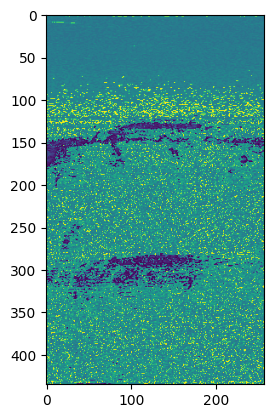

In [356]:
plt.imshow(optimized_map-elevation_map)

In [347]:
a,b=np.unique(heights,return_counts=True)

In [350]:
b

array([131, 122,   6, ...,   1,   1,   1])

In [272]:
points = []
colors = []

for y in range(250,350,1):
    for x in range(W):
        z = y * np.sin(np.radians(elevation_map[y, x]))  # Real Elevation
        points.append([x, y, z])
        
        colors.append(1-jet_colormap[y, x])

# Convert to Point Cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(points))
pcd.colors = o3d.utility.Vector3dVector(np.array(colors))
o3d.visualization.draw_geometries([pcd])

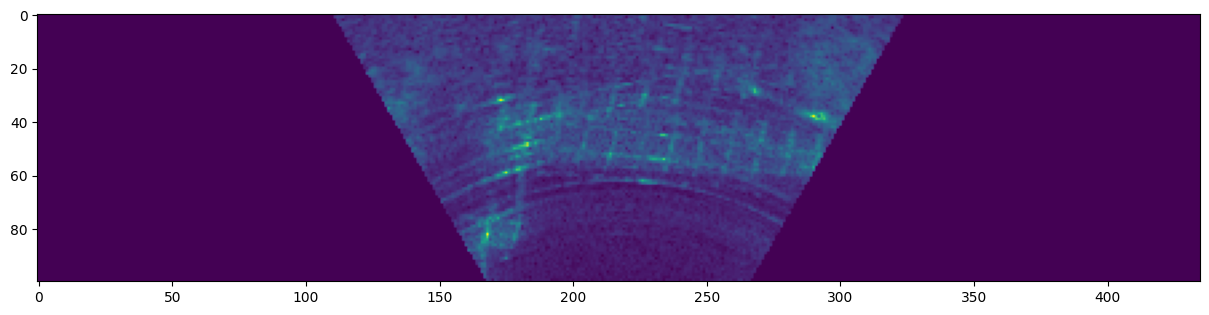

In [273]:
test_img_2=cv2.imread("test_2.png",0)
plt.figure(figsize=(15,15))
plt.imshow(test_img_2[250:350])

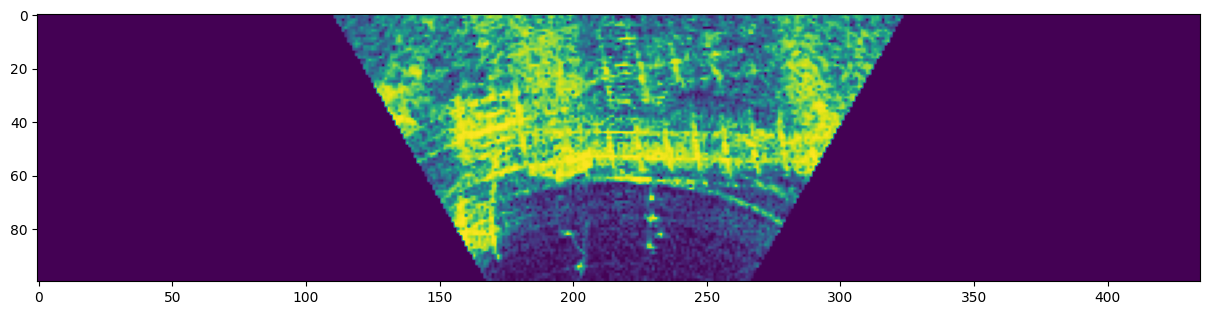

In [320]:
test_img_3=cv2.imread("test_3.png",0)
plt.figure(figsize=(15,15))
plt.imshow(cv2.equalizeHist(test_img_3[250:350]))

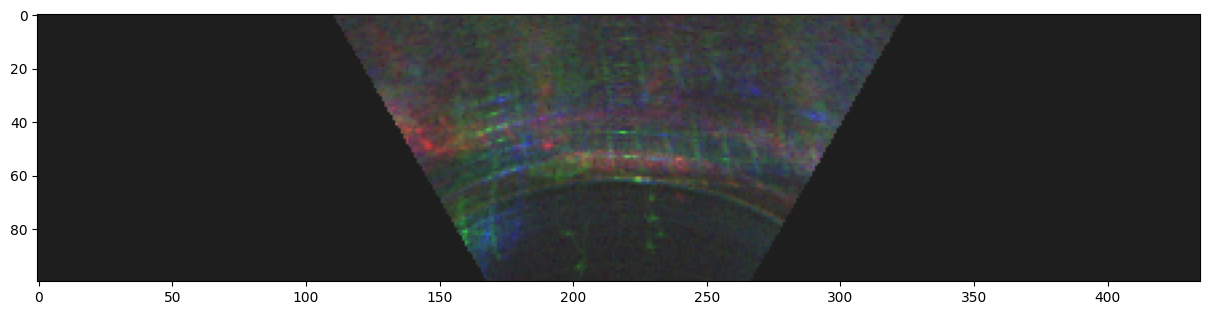

In [232]:
combined_image=cv2.merge([test_img,test_img_3,test_img_2])
plt.figure(figsize=(15,10))
plt.imshow(combined_image[250:350])
plt.imsave("output.png",combined_image)

In [228]:
files=sorted(glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/Oculus_reader/20250212_181120/cartesian/*.png"))
final_img=np.array(np.zeros_like(test_img),np.float32)
for img_path in files:
    img=cv2.imread(img_path,0)
    final_img+=img

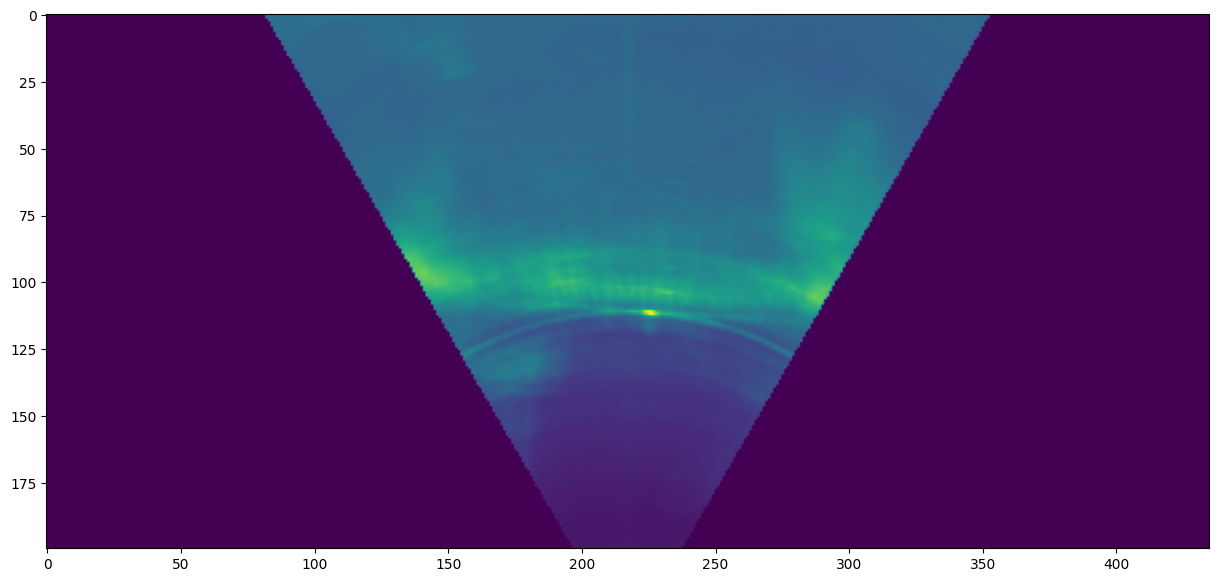

In [231]:
plt.figure(figsize=(15,10))
plt.imshow(final_img[200:400])

In [383]:

import math

from scipy.optimize import root

def soca(img, train_hs, guard_hs, tau):
  print(train_hs)
  """
  Implements Sum-Oriented Constant Amplitude filter based on NumPy.

  Args:
    img: Input image as a NumPy array (assumed to be BGR or grayscale).
    train_hs: Training window half-size.
    guard_hs: Guard window half-size.
    tau: Threshold parameter.

  Returns:
    A 2D NumPy array with filtered binary image.
  """

  # Convert OpenCV image to NumPy array and grayscale (if necessary)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
  blurred_image = cv2.GaussianBlur(img_gray, (7, 7), 0)
  denoised_image = cv2.fastNlMeansDenoising(blurred_image, h=200)


  rows, cols = denoised_image.shape
  ret = np.zeros((rows, cols), dtype=np.uint8)

  for col in range(cols):
    for row in range(train_hs + guard_hs, rows - train_hs - guard_hs):
      leading_sum, lagging_sum = 0.0, 0.0
      for i in range(row - train_hs - guard_hs, row + train_hs + guard_hs + 1):
        if (i - row) > guard_hs:
          lagging_sum += denoised_image[i, col]
        else:
          leading_sum += denoised_image[i, col]
      sum_train = np.min([leading_sum, lagging_sum])
      ret[row, col] = (tau * sum_train / train_hs)

  return ret

def goca(img, train_hs, guard_hs, tau):
  """
  Implements Sum-Oriented Constant Amplitude filter based on NumPy.

  Args:
    img: Input image as a NumPy array (assumed to be BGR or grayscale).
    train_hs: Training window half-size.
    guard_hs: Guard window half-size.
    tau: Threshold parameter.

  Returns:
    A 2D NumPy array with filtered binary image.
  """

  # Convert OpenCV image to NumPy array and grayscale (if necessary)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
  blurred_image = cv2.GaussianBlur(img_gray, (7, 7), 0)
  denoised_image = cv2.fastNlMeansDenoising(blurred_image, h=200)

  rows, cols = denoised_image.shape
  ret = np.zeros((rows, cols), dtype=np.uint8)

  for col in range(cols):
    for row in range(train_hs + guard_hs, rows - train_hs - guard_hs):
      leading_sum, lagging_sum = 0.0, 0.0
      for i in range(row - train_hs - guard_hs, row + train_hs + guard_hs + 1):
        if (i - row) > guard_hs:
          lagging_sum += denoised_image[i, col]
        else:
          leading_sum += denoised_image[i, col]
      sum_train = np.max([leading_sum, lagging_sum])
      ret[row, col] = ((tau * sum_train / train_hs))

  return ret
class CFAR(object):
      """
      Constant False Alarm Rate (CFAR) detection with several variants
          - Cell averaging (CA) CFAR
          - Greatest-of cell-averaging (GOCA) CFAR
          - Order statistic (OS) CFAR
      """

      def __init__(self, Ntc, Ngc, Pfa, rank=None):
          self.Ntc = Ntc #number of training cells
          assert self.Ntc % 2 == 0
          self.Ngc = Ngc #number of guard cells
          assert self.Ngc % 2 == 0
          self.Pfa = Pfa #false alarm rate
          if rank is None: #matrix rank
              self.rank = self.Ntc / 2
          else:
              self.rank = rank
              assert 0 <= self.rank < self.Ntc

          #threshold factor calculation for the 4 variants of CFAR
          self.threshold_factor_SOCA = self.calc_WGN_threshold_factor_SOCA()
          self.threshold_factor_GOCA = self.calc_WGN_threshold_factor_GOCA()


          self.params = {
              
              "SOCA": (self.Ntc // 2, self.Ngc // 2, self.threshold_factor_SOCA),
              "GOCA": (self.Ntc // 2, self.Ngc // 2, self.threshold_factor_GOCA),

          }
          self.detector = {
              
              "SOCA": soca,
              "GOCA": goca,
          
          }
        

      def __str__(self):
          return "".join(
              [
                  "CFAR Detector Information\n",
                  "=========================\n",
                  "Number of training cells: {}\n".format(self.Ntc),
                  "Number of guard cells: {}\n".format(self.Ngc),
                  "Probability of false alarm: {}\n".format(self.Pfa),
                  "Order statictics rank: {}\n".format(self.rank),
                  "Threshold factors:\n",
                
                  "    SOCA-CFAR: {:.3f}\n".format(self.threshold_factor_SOCA),
                  "    GOCA-CFAR: {:.3f}\n".format(self.threshold_factor_GOCA),
          
              ]
          )

      def calc_WGN_threshold_factor_CA(self):
          return self.Ntc * (self.Pfa ** (-1.0 / self.Ntc) - 1)

      def calc_WGN_threshold_factor_SOCA(self):
          x0 = self.calc_WGN_threshold_factor_CA()
          for ratio in np.logspace(-2, 2, 10):
              ret = root(self.calc_WGN_pfa_SOCA, x0 * ratio)
              if ret.success:
                  return ret.x[0]
          raise ValueError("Threshold factor of SOCA not found")

      def calc_WGN_threshold_factor_GOCA(self):
          x0 = self.calc_WGN_threshold_factor_CA()
          for ratio in np.logspace(-2, 2, 10):
              ret = root(self.calc_WGN_pfa_GOCA, x0 * ratio)
              if ret.success:
                  return ret.x[0]
          raise ValueError("Threshold factor of GOCA not found")

      def calc_WGN_pfa_GOSOCA_core(self, x):
          x = float(x)
          temp = 0.0
          for k in range(int(self.Ntc / 2)):
              l1 = math.lgamma(self.Ntc / 2 + k)
              l2 = math.lgamma(k + 1)
              l3 = math.lgamma(self.Ntc / 2)
              temp += math.exp(l1 - l2 - l3) * (2 + x / (self.Ntc / 2)) ** (-k)
          return temp * (2 + x / (self.Ntc / 2)) ** (-self.Ntc / 2)

      def calc_WGN_pfa_SOCA(self, x):
          return self.calc_WGN_pfa_GOSOCA_core(x) - self.Pfa / 2

      def calc_WGN_pfa_GOCA(self, x):
          x = float(x)
          temp = (1.0 + x / (self.Ntc / 2)) ** (-self.Ntc / 2)
          return temp - self.calc_WGN_pfa_GOSOCA_core(x) - self.Pfa / 2


      def detect(self, mat, alg="CA"):
          """
          Return target mask array.
          """
          #pad_width = [(self.Ntc//2 + self.Ngc//2, self.Ntc//2 + self.Ngc//2), (self.Ntc//2 + self.Ngc//2, self.Ntc//2 + self.Ngc//2)]
          #mat=np.pad(mat, pad_width=pad_width, mode='constant', constant_values=0)
          return self.detector[alg](mat, *self.params[alg])

def soca_code(soca_trial):

  # img_gray=cv2.imread("test.png",0)
  img = soca_trial
  cfar_obj=CFAR(4,2,0.95) 

  cfar_result=cfar_obj.detect(img,alg="SOCA")
  return cfar_result 

In [384]:
filter=soca_code(test_img)

/tmp/ipykernel_1467676/1091439947.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)
/tmp/ipykernel_1467676/1091439947.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)


2


In [385]:
np.unique(filter)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

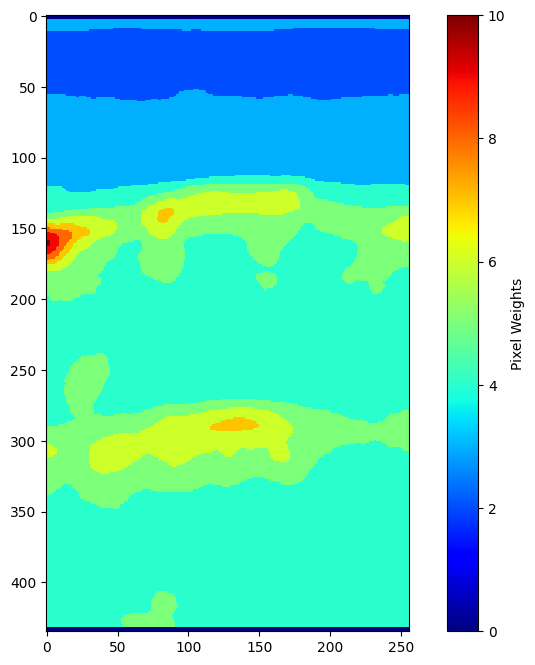

In [386]:
plt.figure(figsize=(10, 8))
plt.imshow(filter, cmap='jet', interpolation='nearest')
plt.colorbar(label='Pixel Weights')

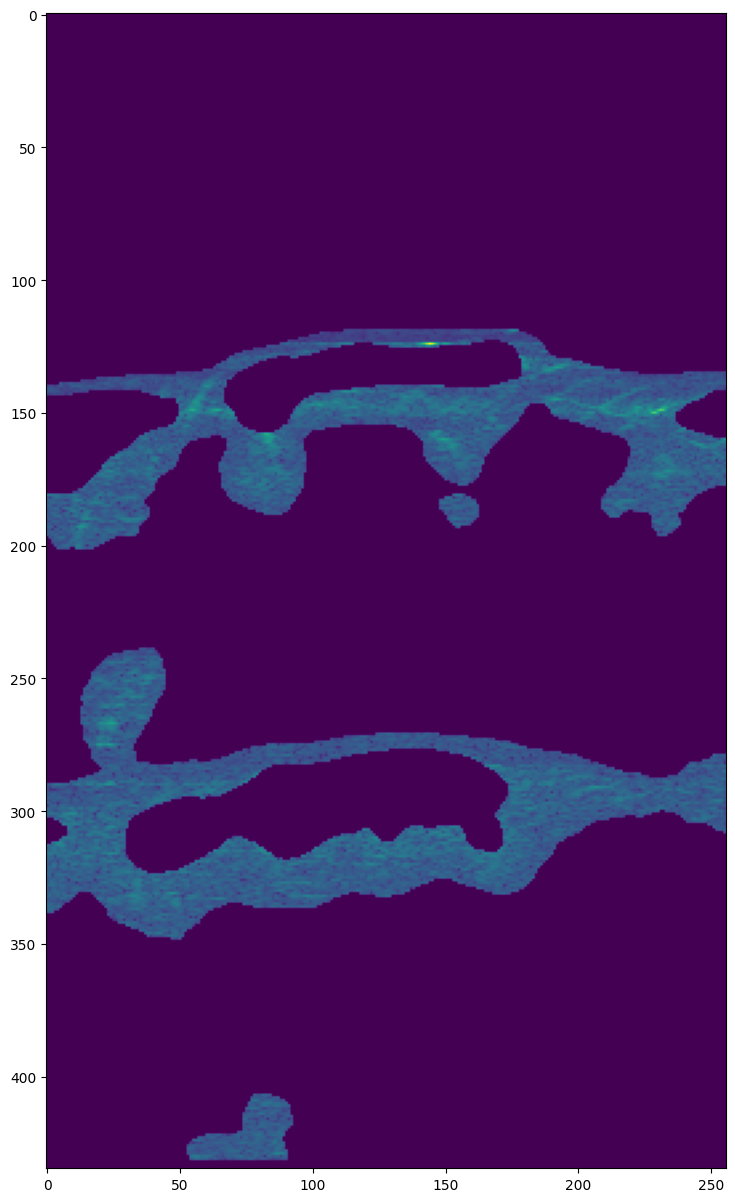

In [390]:
test_cluster=filter==5
denoised=test_cluster*test_img
hist_denoised=(cv2.equalizeHist(denoised))
plt.figure(figsize=(15,15))
plt.imshow(denoised)

In [377]:
test_cluster=filter==4
denoised=test_cluster*test_img
hist_denoised=(cv2.equalizeHist(denoised))

In [378]:
r,binary_image=cv2.threshold(hist_denoised,220,255,cv2.THRESH_BINARY)

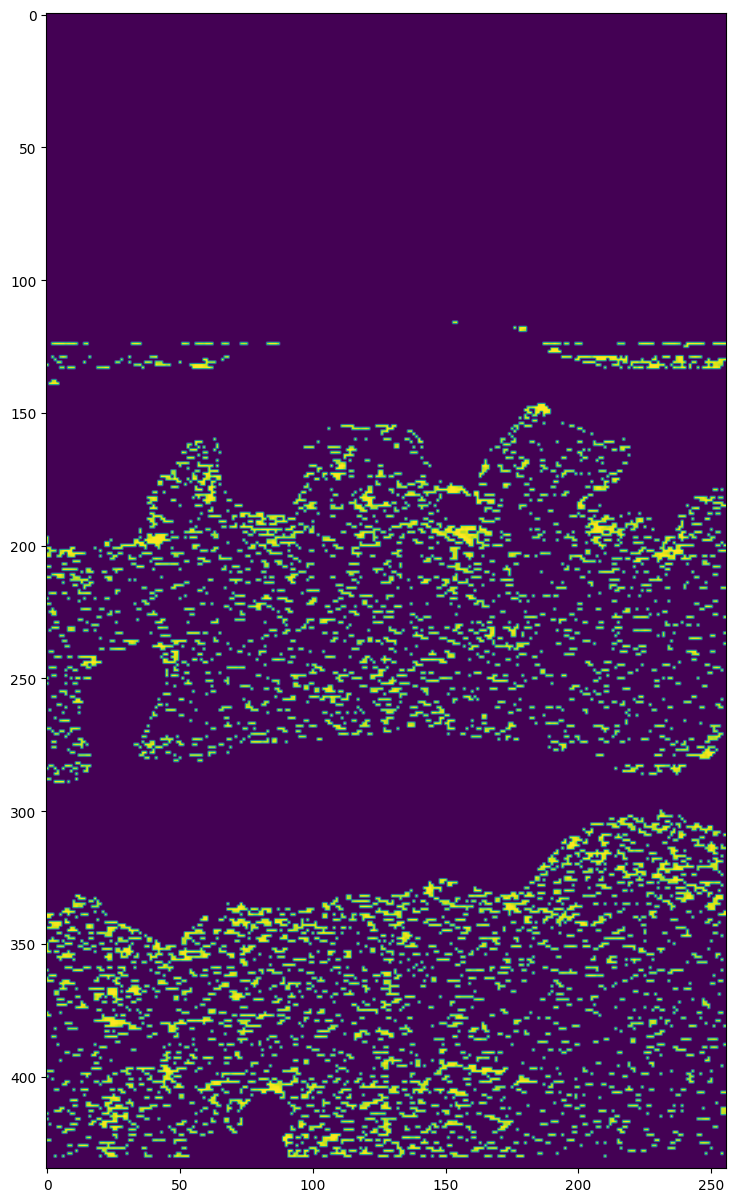

In [379]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.bitwise_and(binary_image,hist_denoised))

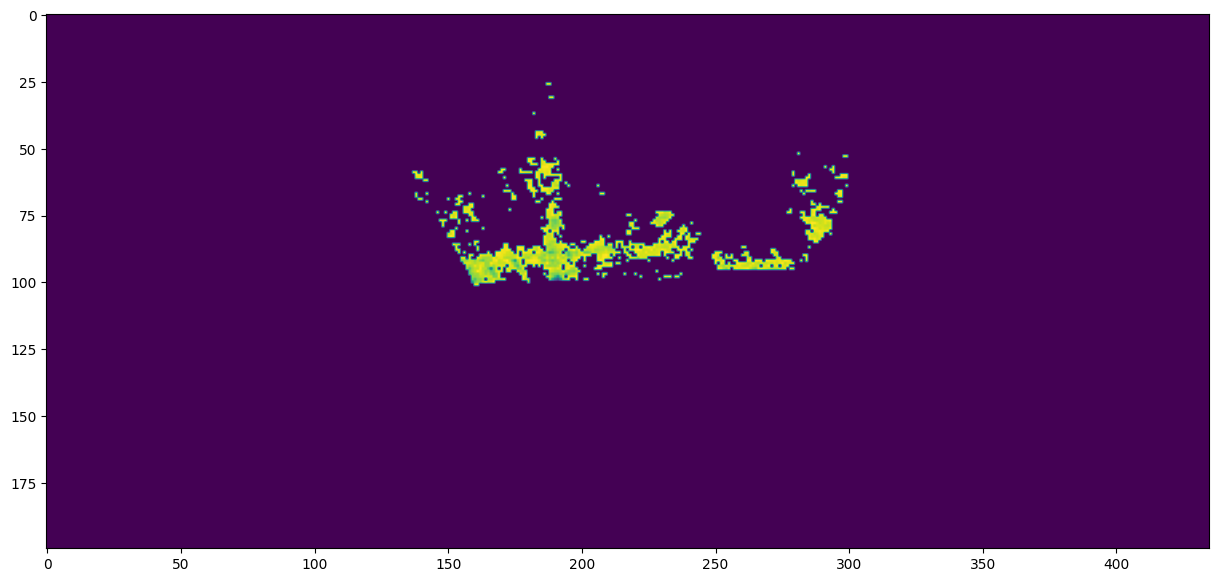

In [250]:
binary_image=binary_image
plt.figure(figsize=(15,15))
plt.imshow(binary_image*denoised/255)

Trying a non Open3D way of visualizing height maps

Where height = range * tan (vertical field of view /2) --> Better to visualize with paper

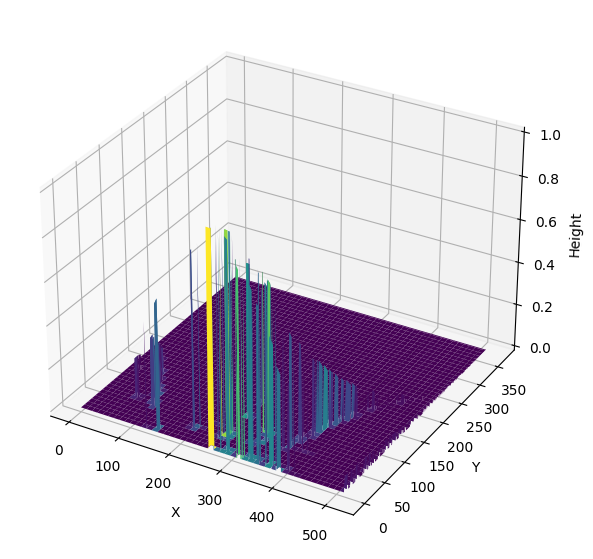

In [5]:


# Generate a 2D binary image
H, W = binary_image.shape

# Sensor origin (bottom center)
x0, y0 = W // 2, 0

# Compute distance and Gaussian parameters
distances = np.zeros_like(binary_image, dtype=float)
sigma_min, k = 100, 0.05  # Gaussian scaling parameters
gaussian_grid = np.zeros((H, W))

for y in range(H):
    for x in range(W):
        if binary_image[y, x] > 0:
            # Compute distance from sensor
            d = np.sqrt((x - x0)**2 + (y - y0)**2)
            distances[y, x] = d
            # Compute Gaussian size
            sigma = sigma_min + k * d
            # Add Gaussian to grid
            gaussian_grid[y, x] = np.exp(-0.5 * (d / sigma)**2)

# Visualization in 3D
X, Y = np.meshgrid(np.arange(W), np.arange(H))
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, gaussian_grid, cmap='viridis')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Height")
plt.show()


The Open3D way, with some coloring scheme (red being high probability, blue being least)

In [5]:
# H, W = 100, 100
# binary_image = np.zeros((H, W))
# circle_center = (50, 50)  # Center of the circle
# circle_radius = 35        # Radius of the circle

# # Create circular boundary
# for y in range(H):
#     for x in range(W):
#         # Check if the point is within the circle
#         if np.sqrt((x - circle_center[0])**2 + (y - circle_center[1])**2) <= circle_radius:
#             binary_image[y, x] = 1

# Sensor origin (bottom center)
H, W = binary_image.shape
x0, y0 = W // 2, 0

# Parameters for Gaussian and uncertainty
sigma_min, k = 50, 0.5  # Gaussian scaling parameters
max_radius = 50  # Circular boundary radius
gaussian_grid = np.zeros((H, W))
uncertainty_grid = np.zeros((H, W))

# Compute Gaussian values and uncertainty
for y in range(H):
    for x in range(W):
        # Compute distance from sensor
        d = np.sqrt((x - x0)**2 + (y - y0)**2)
        if binary_image[y, x] > 0:
            # Compute Gaussian size
            sigma = sigma_min + k * d
            # Add Gaussian to grid
            gaussian_grid[y, x] = np.exp(-0.5 *(d / sigma)**2)
            # Compute uncertainty (inverse of height)
            uncertainty_grid[y, x] = 1 - gaussian_grid[y, x]

# Convert to point cloud for Open3D visualization
points = []
colors = []

for y in range(H):
    for x in range(W):
 # Consider only points within the circular boundary
        z = 100*gaussian_grid[y, x]
        z_vals=np.linspace(-z,z,10)
        certainty = 1 - uncertainty_grid[y, x]
        for z_val in z_vals:
            points.append([x,y,z_val])
            
            colors.append([certainty, 1-certainty, 0])  # Red to green gradient
        # Map uncertainty to color (red = high certainty)
        
        #colors.append([certainty, 1-certainty, 0])  # Red to green gradient
# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize with Open3D
o3d.visualization.draw_geometries([pcd], window_name="Gaussian Height Map")

Trying to plot histograms

In [54]:
vals=[]
for x in range(H):
    for y in range(W):
        vals.append(gaussian_grid[y,x])

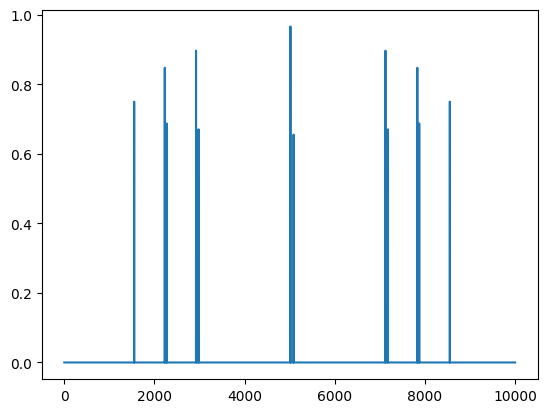

In [55]:
plt.plot(vals)

In [80]:
def generate_binary_circle_image(width, height, radius, center=None):
    """
    Generates a binary image with a circle in the center.

    Args:
        width (int): Width of the image.
        height (int): Height of the image.
        radius (int): Radius of the circle.
        center (tuple, optional): Center coordinates of the circle (x, y). 
                                   Defaults to the center of the image.

    Returns:
        numpy.ndarray: A 2D NumPy array representing the binary image.
    """

    image = np.zeros((height, width), dtype=np.uint8)  # Initialize with zeros (black)

    if center is None:
        center = (width // 2, height // 2)  # Default center

    for y in range(height):
        for x in range(width):
            distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
            if distance <= radius:
                image[y, x] = 255  # Set to 255 (white) if inside the circle

    return image

# Example usage within Jupyter Notebook:
width = 200
height = 200
radius = 15

binary_image = generate_binary_circle_image(width, height, radius)
binary_image = cv2.GaussianBlur(binary_image,(125,125),0)

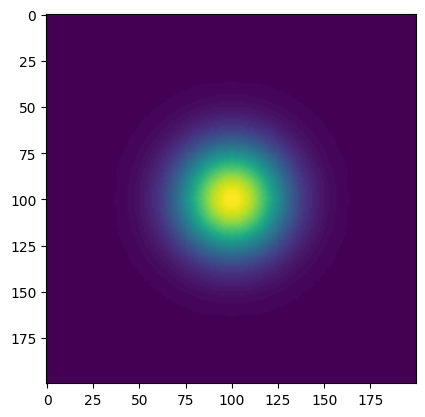

In [81]:
plt.imshow(binary_image)

In [127]:
# Read sonar image sequence
image_list = sorted(glob("./test_stationary_cartesian/*"))[:1]      # List of image paths
#frames = [cv2.imread(img, 0) for img in image_list]
frames=[binary_image for i in range(1000)]
test_img=binary_image
H,W=test_img.shape
phi = np.ones_like(test_img, dtype=float) * (15 + 12 / 2)  # Flat ground assumption
I_model = np.zeros_like(test_img, dtype=float)
beta = 0.6
k = 5
epsilon = 1e-6
alpha=10

for frame in frames:
    # Update Intensity Model
    del_I = frame - I_model
    alpha = k / (I_model + epsilon)
    phi += alpha * del_I
    I_model = beta * I_model + (1 - beta) * frame

# Generate Point Cloud with Absolute Z
points = []
colors = []

for y in range(H):
    for x in range(W):
        z = y * np.sin(np.radians(phi[y, x]))  # Absolute Elevation
        points.append([x, y, z])
        intensity = test_img[y, x] / 255.0
        colors.append([intensity, intensity, intensity])

# Convert to Point Cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(points))
pcd.colors = o3d.utility.Vector3dVector(np.array(colors))
o3d.visualization.draw_geometries([pcd])

In [ ]:
def visualize_point_cloud_cube(size=1.0, center=[0, 0, 0], num_points=1000):
    """
    Generates and visualizes a point cloud representing a cube.

    Args:
        size (float): The side length of the cube.
        center (list): The center coordinates of the cube [x, y, z].
        num_points (int): The number of points in the point cloud.
    """

    points = []
    for _ in range(num_points):
        x = np.random.uniform(-size / 2, size / 2)
        y = np.random.uniform(-size / 2, size / 2)
        z = np.random.uniform(-size / 2, size / 2)
        points.append([x, y, z])

    points = np.array(points)
    points += np.array(center) #translate the points to the desired center

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)

    o3d.visualization.draw_geometries([point_cloud])

In [40]:
visualize_point_cloud_cube(size=2.0, center=[0, 0, 0], num_points=50000)